In [1]:
#Install and import dependencies
!pip install -U tensorflow_datasets

     |████████████████████████████████| 3.3MB 2.8MB/s 
  Found existing installation: tensorflow-datasets 2.1.0
    Uninstalling tensorflow-datasets-2.1.0:
      Successfully uninstalled tensorflow-datasets-2.1.0


In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import seaborn as sns
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential, model_from_json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix
import math 
import itertools

In [3]:
#Loading dataset
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


**Exploring the Dataset**

In [4]:
X = train_images.shape
print("Train_dataset_Details",train_images.shape)
print("Train_label_Details",train_labels.shape)
print("Test_dataset_Details",test_images.shape)
print("Test_label_Details",test_labels.shape)

Train_dataset_Details (60000, 28, 28)
Train_label_Details (60000,)
Test_dataset_Details (10000, 28, 28)
Test_label_Details (10000,)


**Decision**
Thus we see that training dataset having 60000 images where each image pixel size 28x28 i.e. 2-D images, and each pixel is a value from 0 to 255 describing the pixel intensity. 0 for white and 255 for black.

Where we know the class labels for Fashion MNIST are:
```
Label   Description
0         T-shirt/top
1         Trouser
2         Pullover
3         Dress
4         Coat
5         Sandal
6         Shirt
7         Sneaker
8         Bag
9         Ankle boot
```



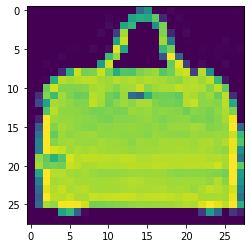

In [5]:
plt.figure()
plt.imshow((train_images[220]))

In [6]:
train_labels[220]

8

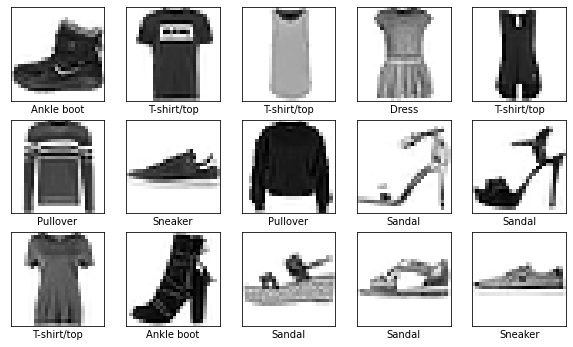

In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()


Now, since, we have one more dimension for the images i.e. Channels (color), let us add it to the dimensions of train_images and test_images by using reshape() function. Since here the color is black and white there for we will use 1 (hence, channels=1) i.e. 'grayscale'.

In [0]:
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

Let us normalize these values to a range from 0 to 1. To do this, we can simply divide each pixel value with 255

In [0]:
train_images_norm = train_images / 255.0
test_images_norm = test_images / 255.0

In [0]:
# First convolutional layer. 
# Number of neurons = 32
# filter(kernel) size = 3x3
# Activation function = Relu
# input data (images) size (height, width, channels) = (28, 28, 1)
# Channels is 'colors' here. Since fashion MNIST images are grayscale, number of colors = 1, hence, channels = 1

firstconvolayer = layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1) )

In [0]:
# Second convolutional layer. 
# Number of neurons = 64
# filter(kernel) size = 3x3
# Activation function = Relu
# No separate input data for this layer, input to this layer are the 'weights' of the firstconvolayer featureMaps
# no need to specify explicitly the input to the other convolutional layers (except for the first layer, as above)
secondconvolayer = layers.Conv2D(64, (3,3), activation='relu')

In [0]:
# Third convolutional layer. 
# Number of neurons = 128
# filter(kernel) size = 3x3
# Activation function = Relu
# No separate input data for this layer, input to this layer are the 'weights' of the secondconvolayer featureMaps
# no need to specify explicitly the input to the other convolutional layers (except for the first layer, as above)
thirdconvolayer = layers.Conv2D(128, (3,3), activation='relu')

In [0]:
# Max Pool Layer
# Since input to CNN is a 2-D image and ouput from last convolutional layer (featuerMap) is also 2-D array 
# (except the third dimension i.e. channels), we will use 2D version of Max Pooling function of TensorFlow Keras
# to create a Max Pooling Layer, as shown below filter (kernel) size for Pooling Layer = 2x2


#Creating first Max. Pooling Layer
max_pool_1 = layers.MaxPooling2D((2,2))

#Creating second Max. Pooling Layer
max_pool_2 = layers.MaxPooling2D((2,2))

#Creating third Max. Pooling Layer
max_pool_3 = layers.MaxPooling2D((2,2))

In [0]:
# Fully Connected (FC) Layer i.e. hidden layer expects input in 1-D format (1-D array), hence, we need to convert
# 2-D output (2-D array) of last convolutional layer (conv3) to 1-D array i.e. we need to flatten the 2-D array
# to 1-D array

flat_layer = layers.Flatten()

In [0]:
# Fully Connected (FC) Layer - Hidden(Dense) Layer
# Normally, the number of neurons that we keep in FC layer should be equal to the number of neurons in just
# immediate previous convolutional layer

fc = layers.Dense(128, activation='relu')

In [0]:
# Output Layer - with 10 neurons (as we have 10 output classes) and using 'softmax' function
output = layers.Dense(10, 'softmax')

Since we need to overcome overfitting there for we are going to use the simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters (number of layers and the number of neurons per layer). Second option to remove overfitting is to use Regularization techniques like - L1, L2, Dropout.

In [0]:
# Creating first dropout layer (for the first Conv. layer 'conv1')
drop_1 = keras.layers.Dropout(0.5)
# Creating second dropout layer (for the second Conv. layer 'conv2')
drop_2 = keras.layers.Dropout(0.25)
# Creating third dropout layer (for the third Conv. layer 'conv3')
drop_3 = keras.layers.Dropout(0.5)

In [0]:
# Let us create a new neural network by applying these above created Dropout Layers to the respecive convolutional Layers 
# Please note that the Dropout layer for all the convolutional layers will be applied after the pooling layer (max. pool layer)

new_model = models.Sequential()

new_model.add(firstconvolayer)
# No Pooling Layer and Dropout layer for first Convolutional layer 'conv1'
new_model.add(secondconvolayer)
new_model.add(max_pool_2)
new_model.add(drop_2)
new_model.add(thirdconvolayer)
new_model.add(max_pool_3)
new_model.add(drop_3)
new_model.add(flat_layer)
new_model.add(fc)
new_model.add(output)

In [36]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 128)        

In [0]:
new_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
 #Let us perform 30 epochs with batch_size as 512, and with shuffling = true 
# shuffle=true will shuffle the indexes of the instances in order to allocate different sets of instances 
# in validation dataset each time cross-validation runs
# validation split=0.1 means a validation dataset of size of 10% is created from the training dataset for cross validation

history = new_model.fit(train_images_norm, train_labels, epochs=30, batch_size=512, shuffle=True, validation_split=0.1)

Epoch 1/30
106/106 [==============================] - 6s 61ms/step - loss: 0.1464 - accuracy: 0.9472 - val_loss: 0.1959 - val_accuracy: 0.9317
Epoch 2/30
106/106 [==============================] - 6s 56ms/step - loss: 0.1234 - accuracy: 0.9540 - val_loss: 0.1945 - val_accuracy: 0.9323
Epoch 3/30
106/106 [==============================] - 6s 56ms/step - loss: 0.1217 - accuracy: 0.9549 - val_loss: 0.1860 - val_accuracy: 0.9337
Epoch 4/30
106/106 [==============================] - 6s 56ms/step - loss: 0.1122 - accuracy: 0.9580 - val_loss: 0.1864 - val_accuracy: 0.9335
Epoch 5/30
106/106 [==============================] - 6s 56ms/step - loss: 0.1124 - accuracy: 0.9567 - val_loss: 0.1844 - val_accuracy: 0.9348
Epoch 6/30
106/106 [==============================] - 6s 56ms/step - loss: 0.1081 - accuracy: 0.9590 - val_loss: 0.1874 - val_accuracy: 0.9318
Epoch 7/30
106/106 [==============================] - 6s 56ms/step - loss: 0.1039 - accuracy: 0.9605 - val_loss: 0.1872 - val_accuracy: 0.9333

In [39]:
test_loss, test_accuracy = new_model.evaluate(test_images_norm, test_labels)

313/313 [==============================] - 1s 5ms/step - loss: 0.2211 - accuracy: 0.9329


In [40]:
print(test_accuracy)

0.9329000115394592


In [41]:
print(test_loss)

0.2210739403963089


In [42]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


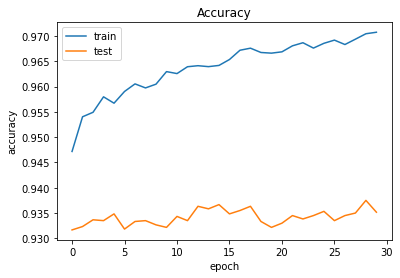

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc='upper left')
plt.show()

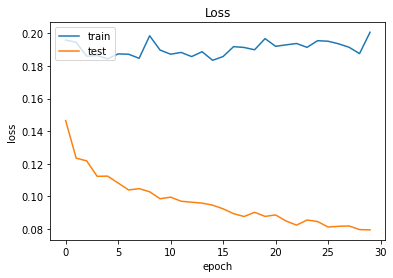

In [51]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Making predictions on Test dataset
predicted_test_labels = new_model.predict(test_images_norm)

In [46]:
predicted_test_labels.shape

(10000, 10)

In [47]:
predicted_test_labels[88]

array([9.9999821e-01, 4.0275664e-18, 9.4601367e-09, 6.7962293e-07,
       4.9095788e-12, 1.1297372e-14, 1.0977793e-06, 7.5356041e-17,
       4.0764733e-10, 7.6349713e-16], dtype=float32)

In [48]:
predicted_test_labels_index = np.argmax(predicted_test_labels[88])
predicted_test_labels_index

0

In [49]:
test_labels[88]

0

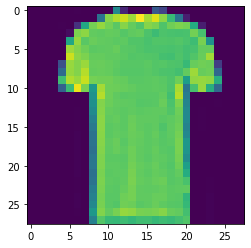

In [50]:
plt.figure()
plt.imshow(np.squeeze(test_images[88]))

Creating a advanced model with some new features.

In [0]:
model = Sequential()

#1. LAYER
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

#2. LAYER
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same'))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPool2D(pool_size=(2, 2)))

#3. LAYER
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
model.add(BatchNormalization())
model.add(Activation("relu"))

#4. LAYER
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPool2D(pool_size=(2, 2)))

#FULLY CONNECTED LAYER
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))

#OUTPUT LAYER
model.add(Dense(10, activation='softmax'))

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Thus, we see that our prediction of the image at index 88 is right (T-shirt).

In [66]:
# Setting Random Seeds for Reproducibilty.
seed = 66
np.random.seed(seed)
X = train_images_norm
Y = train_labels
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(54000, 28, 28, 1)
(6000, 28, 28, 1)
(54000,)
(6000,)


In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])

batch_stats = CollectBatchStats()

In [70]:
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
aug_num = 10 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range= 0.8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = aug_num / 100, # Randomly zoom image 
        width_shift_range= aug_num / 100,  # randomly shift images horizontally (fraction of total width)
        height_shift_range= aug_num / 100,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=0.05,  # randomly flip images horizontally
        vertical_flip=True)  # randomly flip images vertically
        
datagen.fit(x_train)
batch_size = 128
epochs =  30
# Fit the Model
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (x_test, y_test), verbose=2, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=[reduce_lr])

Epoch 1/30
 - 25s - loss: 0.3443 - accuracy: 0.8776 - val_loss: 0.2107 - val_accuracy: 0.9288
Epoch 2/30
 - 24s - loss: 0.2651 - accuracy: 0.9037 - val_loss: 0.1891 - val_accuracy: 0.9330
Epoch 3/30
 - 24s - loss: 0.2449 - accuracy: 0.9092 - val_loss: 0.1919 - val_accuracy: 0.9302
Epoch 4/30
 - 25s - loss: 0.2341 - accuracy: 0.9134 - val_loss: 0.1958 - val_accuracy: 0.9307
Epoch 5/30
 - 24s - loss: 0.2280 - accuracy: 0.9175 - val_loss: 0.1863 - val_accuracy: 0.9367
Epoch 6/30
 - 24s - loss: 0.2167 - accuracy: 0.9207 - val_loss: 0.1815 - val_accuracy: 0.9365
Epoch 7/30
 - 25s - loss: 0.2108 - accuracy: 0.9215 - val_loss: 0.1765 - val_accuracy: 0.9363
Epoch 8/30
 - 24s - loss: 0.2044 - accuracy: 0.9232 - val_loss: 0.1932 - val_accuracy: 0.9333
Epoch 9/30
 - 24s - loss: 0.1997 - accuracy: 0.9266 - val_loss: 0.1823 - val_accuracy: 0.9377
Epoch 10/30
 - 25s - loss: 0.1972 - accuracy: 0.9273 - val_loss: 0.1674 - val_accuracy: 0.9410
Epoch 11/30
 - 24s - loss: 0.1899 - accuracy: 0.9306 - val_

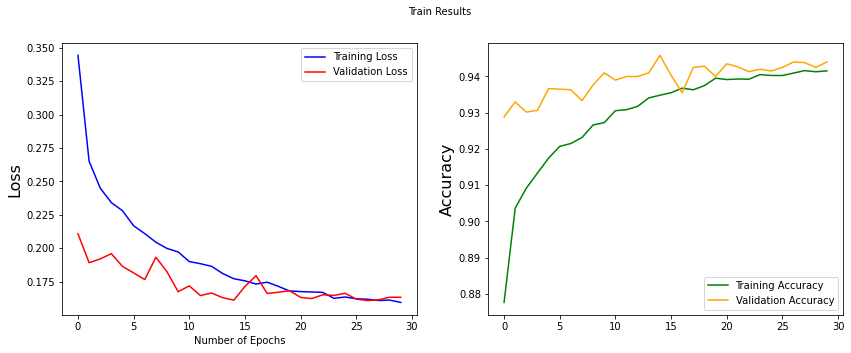

In [71]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.suptitle('Train Results', fontsize=10)
plt.xlabel("Number of Epochs")
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], color='green', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [72]:
print('Train accuracy of the model: ',history.history['accuracy'][-1])

Train accuracy of the model:  0.9415466


In [73]:
print('Train loss of the model: ',history.history['loss'][-1])

Train loss of the model:  0.15933453283909702


In [74]:
print('Validation accuracy of the model: ',history.history['val_accuracy'][-1])

Validation accuracy of the model:  0.9440000057220459


In [75]:
print('Validation loss of the model: ',history.history['val_loss'][-1])

Validation loss of the model:  0.16319409972429275


In [76]:
score = model.evaluate(x_test,y_test,verbose=0)
print("Test Loss:",score[0])
print("Test Accuracy:",score[1])

Test Loss: 0.16319409878055255
Test Accuracy: 0.9440000057220459


(6000, 28, 28, 1)


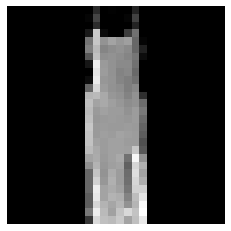

In [77]:
print(x_test.shape)
plt.imshow(x_test[1].reshape(28,28),cmap="gray")
plt.axis("off")
plt.show()

In [78]:
trueY = y_test[1]
img = x_test[1]
test_img = img.reshape(1,28,28,1)

preds = model.predict_classes(test_img)
prob = model.predict_proba(test_img)

print("trueY: ",np.argmax(trueY))
print("Preds: ",preds)
print("Prob: ",prob)

trueY:  0
Preds:  [3]
Prob:  [[6.15611323e-04 7.16845898e-05 1.00428570e-05 9.99143004e-01
  1.09778175e-05 2.49791896e-07 1.33046575e-04 8.17618400e-08
  1.45328058e-05 8.22841059e-07]]


In [0]:
Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(y_test)


In [80]:
from keras.utils.np_utils import to_categorical 

# convert to one-hot-encoding(one hot vectors)
Y_train = to_categorical(y_train, num_classes = 10)
# convert to one-hot-encoding(one hot vectors)
Y_test = to_categorical(y_test, num_classes = 10)

print(Y_train.shape)
print(Y_test.shape)

(54000, 10)
(6000, 10)


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

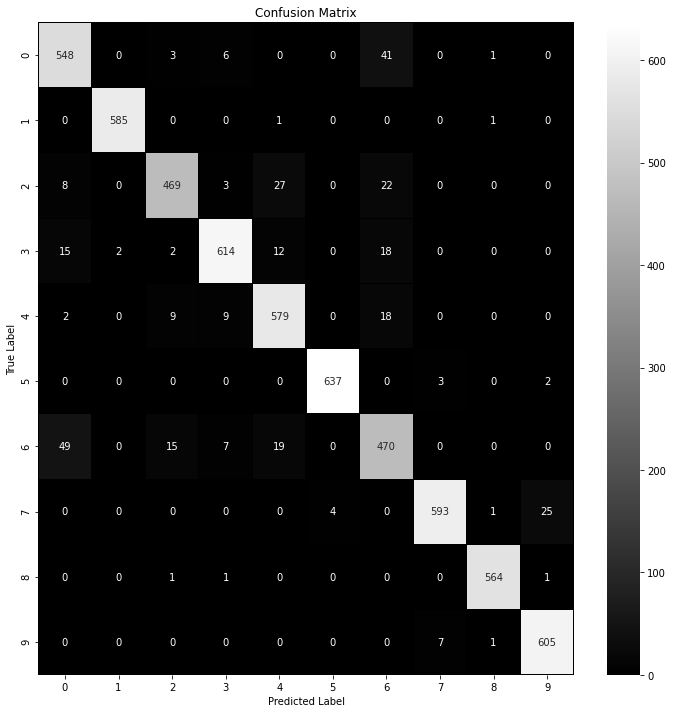

In [82]:
Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_test, axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize = (12,12))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

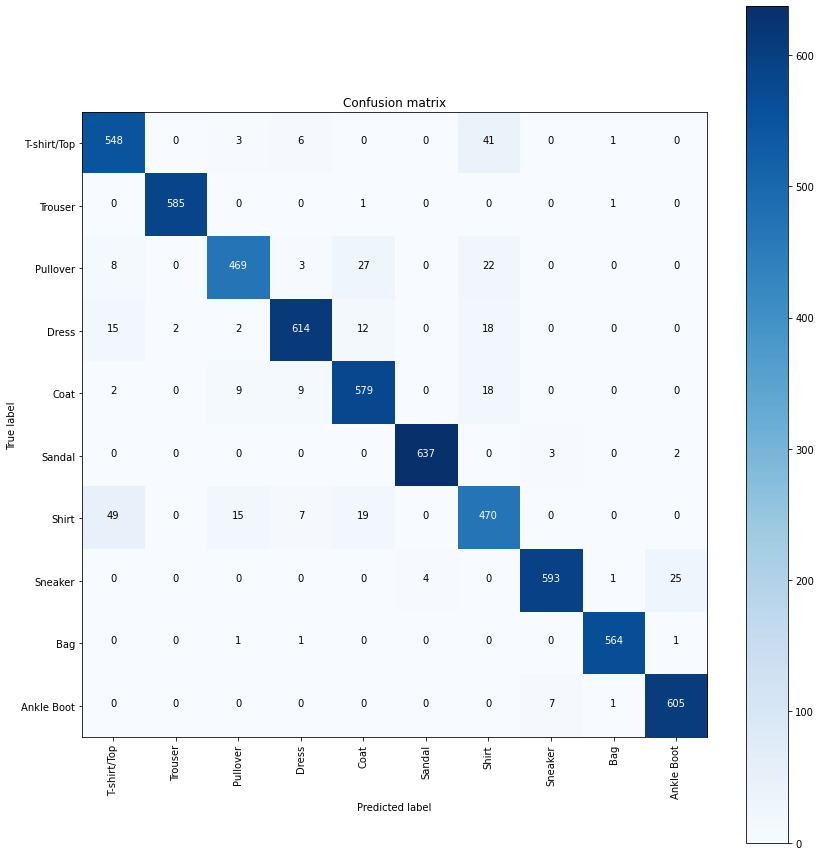

In [83]:
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize = (12,12))
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])